# Regression with Different Output Format under Various Data Conditions

In this experience, we test the following output format for regression task under several different data coditions.
- Numerical output
- Regression as classification (grid-out)

The data coditions include:
- Sparse (few data)
- Grouped
  - Biased (parallel data)
  - Completely different mode, uncorrelated data (cross)
  - Partially diversed (split)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def draw_func(func_in, x_min=-5, x_max=5, mark='r--', linewidth=1, label='func'):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func)
    plt.plot(X_func, y_func, mark, linewidth=linewidth, label=label)

Generate polynomial data

In [3]:
def func_0(X): # Reference
    return 0.5 * X**3 + 0.5 * X**2 + X + 2
def func_1(X): # Variation 1: parellel
    return 0.5 * X**3 + 0.5 * X**2 + X + 30
def func_2(X): # Variation 2: cross
    return -0.5 * X**3 + 0.5 * X**2 + X + 30
def func_3(X): # Variation 3: slightly split
    return 0.3 * X**3 + 1.0 * X**2 + X + 15 

In [4]:
func_dict = dict()
func_dict["f1"] = func_0
# func_dict["f2"] = func_1
# func_dict["f2"] = func_2
func_dict["f2"] = func_3

# Average line
func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )

In [5]:
def draw_normal_func(func_dict):
    draw_func(func_dict["f1"], mark='c:', label="f1")
    draw_func(func_dict["f2"], mark='g:', label="f2")
    draw_func(func_dict["f_avg"], mark='m--', label="f_avg")

In [6]:
np.random.seed(42)
m = 100 # 50 # 100 # 200
m_train = m // 5 * 4
print("(m, m_train) = (%d, %d)" % (m, m_train))
# Input
X_data = 10 * np.random.rand(m, 1) - 5 # Note: X is randomly sampled, so we don't need to shuffle the data again

# Output
is_multiout = True
# is_multiout = False
if is_multiout:
    m_h = m // 2
    X_data_1 = X_data[:m_h]
    X_data_2 = X_data[m_h:]
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
else:        
    y_data_pure = 0.5 * X_data**3 + 0.5 * X_data**2 + X_data + 2 

# Label (+noise)
n_stddev = 2.0
# n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 1) * n_stddev
print("y_data.shape = %s" % str(y_data.shape))

(m, m_train) = (100, 80)
y_data_pure.shape = (100, 1)
y_data.shape = (100, 1)


In [7]:
X_train = X_data[:m_train]
y_train = y_data[:m_train]
X_valid = X_data[m_train:]
y_valid = y_data[m_train:]

In [8]:
print(X_train.shape)

(80, 1)


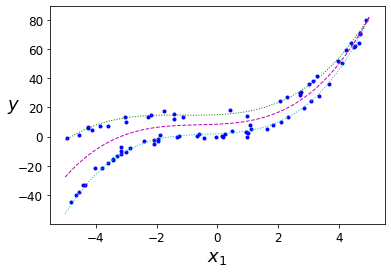

In [9]:
plt.plot(X_train, y_train, "b.")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Simple FCs (number --> number)

Build the regression model

In [10]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - 2s 305ms/step - loss: 759.9342 - val_loss: 379.7631
Epoch 2/100
3/3 [==============================] - 0s 49ms/step - loss: 415.4963 - val_loss: 216.9349
Epoch 3/100
3/3 [==============================] - 0s 75ms/step - loss: 518.5781 - val_loss: 456.9099
Epoch 4/100
3/3 [==============================] - 0s 59ms/step - loss: 743.0277 - val_loss: 592.2623
Epoch 5/100
3/3 [==============================] - 0s 83ms/step - loss: 769.3848 - val_loss: 607.8243
Epoch 6/100
3/3 [==============================] - 0s 50ms/step - loss: 738.5383 - val_loss: 562.8845
Epoch 7/100
3/3 [==============================] - 0s 78ms/step - loss: 631.0479 - val_loss: 303.0822
Epoch 8/100
3/3 [==============================] - 0s 45ms/step - loss: 291.2781 - val_loss: 335.9977
Epoch 9/100
3/3 [==============================] - 0s 50ms/step - loss: 316.6118 - val_loss: 368.7188
Epoch 10/100
3/3 [==============================] - 0s 97ms/step - loss: 473.5811

3/3 [==============================] - 0s 101ms/step - loss: 110.4554 - val_loss: 178.9028
Epoch 81/100
3/3 [==============================] - 0s 74ms/step - loss: 105.9848 - val_loss: 166.8691
Epoch 82/100
3/3 [==============================] - 0s 58ms/step - loss: 102.0802 - val_loss: 178.1682
Epoch 83/100
3/3 [==============================] - 0s 69ms/step - loss: 103.5603 - val_loss: 175.2199
Epoch 84/100
3/3 [==============================] - 0s 57ms/step - loss: 102.3210 - val_loss: 162.6452
Epoch 85/100
3/3 [==============================] - 0s 85ms/step - loss: 100.7425 - val_loss: 181.0675
Epoch 86/100
3/3 [==============================] - 0s 52ms/step - loss: 103.7121 - val_loss: 181.7385
Epoch 87/100
3/3 [==============================] - 0s 63ms/step - loss: 109.2200 - val_loss: 147.0350
Epoch 88/100
3/3 [==============================] - 0s 91ms/step - loss: 103.4440 - val_loss: 198.0678
Epoch 89/100
3/3 [==============================] - 0s 58ms/step - loss: 102.5593 - v

Plot the result

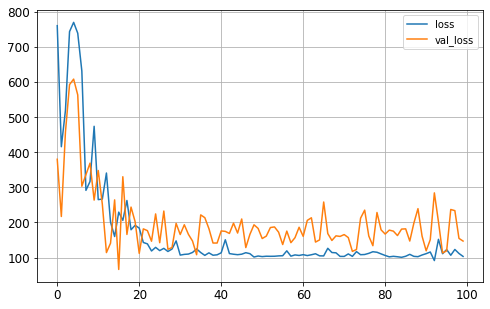

In [12]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

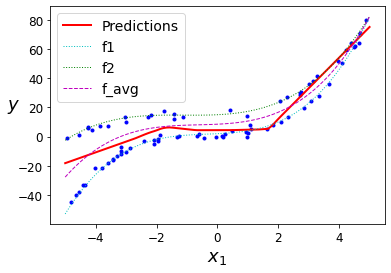

In [13]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Simulated CNN Feature Map (1-D grids, grid --> number)

In [14]:
class num2grid(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit) 
        
        self.x_grid shape: (grid_unit,)
        '''
        gauss_grid = tf.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
        print("X.shape = %s" % str(X.shape))
        print("gauss_grid.shape = %s" % str(gauss_grid.shape))
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

In [15]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 733.8754X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 140ms/step - loss: 810.9073 - val_loss: 545.2546
Epoch 2/100
3/3 [==============================] - 0s 49ms/step - loss: 791.6259 - val_loss: 502.0811
Epoch 3/100
3/3 [==============================] - 0s 51ms/step - loss: 753.2899 - val_loss: 431.6254
Epoch 4/100
3/3 [==============================] - 0s 84ms/step - loss: 689.7057 - val_loss: 311.3961
Epoch 5/100
3/3 [==============================] - 0s 77ms/step - loss: 605.1418 - val_loss: 153.7826
Epoch 6/100
3/3 [==============================] - 0s 49ms/step - loss: 522.7314 - val_loss: 64.8767
Epoch 7/100
3/3 [==============================] - 0s 81ms/step - loss: 436.2332 - val_loss: 45.1136
Epoch 8/100
3/3 [==============================] - 0s 88ms/step - loss: 317.5

3/3 [==============================] - 0s 44ms/step - loss: 103.4165 - val_loss: 194.6131
Epoch 79/100
3/3 [==============================] - 0s 46ms/step - loss: 102.7498 - val_loss: 193.8988
Epoch 80/100
3/3 [==============================] - 0s 60ms/step - loss: 101.9726 - val_loss: 193.7993
Epoch 81/100
3/3 [==============================] - 0s 51ms/step - loss: 102.0262 - val_loss: 191.3059
Epoch 82/100
3/3 [==============================] - 0s 46ms/step - loss: 102.7648 - val_loss: 185.0421
Epoch 83/100
3/3 [==============================] - 0s 59ms/step - loss: 102.4381 - val_loss: 181.7990
Epoch 84/100
3/3 [==============================] - 0s 76ms/step - loss: 102.9103 - val_loss: 180.9976
Epoch 85/100
3/3 [==============================] - 0s 61ms/step - loss: 101.8811 - val_loss: 174.1638
Epoch 86/100
3/3 [==============================] - 0s 94ms/step - loss: 102.1085 - val_loss: 174.8595
Epoch 87/100
3/3 [==============================] - 0s 85ms/step - loss: 102.1173 - va

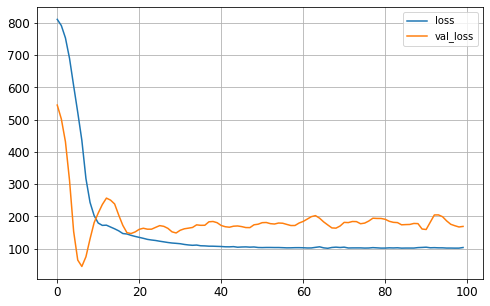

In [17]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


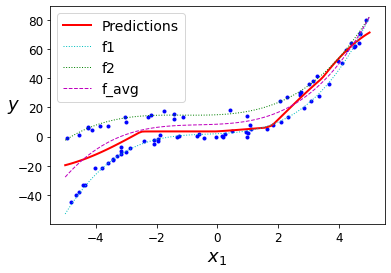

In [18]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Grid & Regression by Classification (grid --> grid)

In [19]:
class num2grid_np():
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        print("self.x_grid = %s" % str(self.x_grid))
        
    def convert(self, X):
        gauss_grid = np.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
#         if len(gauss_grid.shape) == 1:
#             gauss_grid = gauss_grid.reshape([1,-1])
#         grid_sum = np.sum(gauss_grid, axis=1, keepdims=True)
        grid_sum = np.sum(gauss_grid, axis=-1, keepdims=True)
        gauss_grid = gauss_grid / grid_sum
        return gauss_grid
    
    def inv_convert(self, grid):
#         if len(grid.shape) == 1:
#             grid = grid.reshape([1,-1])
#         grid_sum = np.sum(grid, axis=1)
        grid_sum = np.sum(grid, axis=-1)
#         print(grid_sum)
        exp_num = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        return exp_num

In [20]:
# class_num = 10 # 10
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=20.0) 
class_num = 50
n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=5.0) # 5.0 

self.x_grid = [-100.          -95.91836735  -91.83673469  -87.75510204  -83.67346939
  -79.59183673  -75.51020408  -71.42857143  -67.34693878  -63.26530612
  -59.18367347  -55.10204082  -51.02040816  -46.93877551  -42.85714286
  -38.7755102   -34.69387755  -30.6122449   -26.53061224  -22.44897959
  -18.36734694  -14.28571429  -10.20408163   -6.12244898   -2.04081633
    2.04081633    6.12244898   10.20408163   14.28571429   18.36734694
   22.44897959   26.53061224   30.6122449    34.69387755   38.7755102
   42.85714286   46.93877551   51.02040816   55.10204082   59.18367347
   63.26530612   67.34693878   71.42857143   75.51020408   79.59183673
   83.67346939   87.75510204   91.83673469   95.91836735  100.        ]


In [21]:
grid_1 = n2g.convert(-1.2)
print(grid_1)

[5.32087956e-86 3.86113319e-79 1.43892139e-72 2.75391345e-66
 2.70678923e-60 1.36631087e-54 3.54189384e-49 4.71533431e-44
 3.22389115e-39 1.13198112e-34 2.04121584e-30 1.89029511e-26
 8.99003166e-23 2.19575442e-19 2.75421121e-16 1.77419623e-13
 5.86944439e-11 9.97202289e-09 8.70082579e-07 3.89877895e-05
 8.97196734e-04 1.06032179e-02 6.43544562e-02 2.00590561e-01
 3.21094817e-01 2.63965415e-01 1.11442718e-01 2.41628020e-02
 2.69050515e-03 1.53854886e-04 4.51834812e-06 6.81457879e-08
 5.27824177e-10 2.09957055e-12 4.28906472e-15 4.49972175e-18
 2.42437419e-21 6.70817796e-25 9.53235992e-29 6.95644285e-33
 2.60714354e-37 5.01803398e-42 4.96013143e-47 2.51793030e-52
 6.56425064e-58 8.78855631e-64 6.04283668e-70 2.13380686e-76
 3.86954844e-83 3.60376450e-90]


In [22]:
n2g.inv_convert(grid_1)

-1.2000000000101176

### Convert the labels to grid (pre-processing)

In [23]:
y_train_grid = n2g.convert(y_train)
y_valid_grid = n2g.convert(y_valid)

In [24]:
print(y_train_grid.shape)
print(y_valid_grid.shape)

(80, 50)
(20, 50)


In [25]:
model = keras.models.Sequential([
#     keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(class_num, activation="softmax"),
])

optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
history = model.fit(X_train, y_train_grid, epochs=100,
                    validation_data=(X_valid, y_valid_grid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 3.9046X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 249ms/step - loss: 3.9111 - val_loss: 3.8516
Epoch 2/100
3/3 [==============================] - 0s 63ms/step - loss: 3.8467 - val_loss: 3.7595
Epoch 3/100
3/3 [==============================] - 0s 113ms/step - loss: 3.7427 - val_loss: 3.6412
Epoch 4/100
3/3 [==============================] - 0s 106ms/step - loss: 3.6023 - val_loss: 3.5000
Epoch 5/100
3/3 [==============================] - 0s 96ms/step - loss: 3.4537 - val_loss: 3.3573
Epoch 6/100
3/3 [==============================] - 0s 97ms/step - loss: 3.3088 - val_loss: 3.2565
Epoch 7/100
3/3 [==============================] - 0s 84ms/step - loss: 3.2162 - val_loss: 3.1646
Epoch 8/100
3/3 [==============================] - 0s 89ms/step - loss: 3.1703 - val_loss: 3.0377
Epoch

3/3 [==============================] - 0s 36ms/step - loss: 2.3251 - val_loss: 2.5768
Epoch 82/100
3/3 [==============================] - 0s 48ms/step - loss: 2.3207 - val_loss: 2.5851
Epoch 83/100
3/3 [==============================] - 0s 46ms/step - loss: 2.3195 - val_loss: 2.6047
Epoch 84/100
3/3 [==============================] - 0s 43ms/step - loss: 2.3239 - val_loss: 2.5261
Epoch 85/100
3/3 [==============================] - 0s 46ms/step - loss: 2.3209 - val_loss: 2.6040
Epoch 86/100
3/3 [==============================] - 0s 46ms/step - loss: 2.3097 - val_loss: 2.5467
Epoch 87/100
3/3 [==============================] - 0s 44ms/step - loss: 2.3066 - val_loss: 2.5591
Epoch 88/100
3/3 [==============================] - 0s 46ms/step - loss: 2.3119 - val_loss: 2.6076
Epoch 89/100
3/3 [==============================] - 0s 43ms/step - loss: 2.3050 - val_loss: 2.4890
Epoch 90/100
3/3 [==============================] - 0s 39ms/step - loss: 2.3046 - val_loss: 2.4920
Epoch 91/100
3/3 [=====

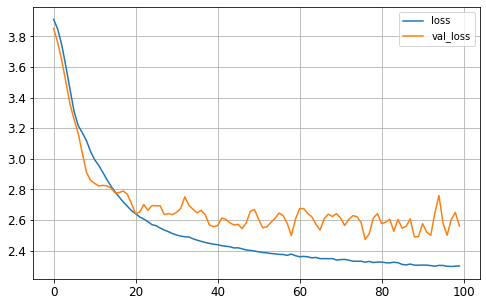

In [27]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


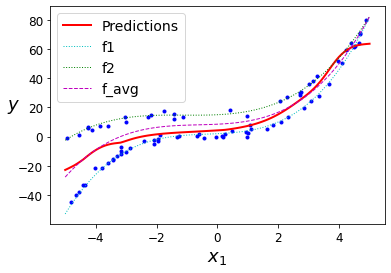

In [28]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

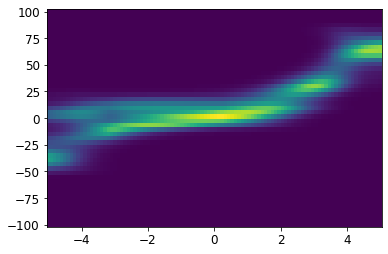

In [29]:
X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
xv, yv = np.meshgrid(X_new, np.linspace(n2g.x_min, n2g.x_max, n2g.units))
# print(xv)
# print(yv)
plt.pcolormesh(xv, yv, y_new_proba.T, shading="nearest")